In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from constants import (CATEGORICAL_FEATURES, DATA_PATH, LABEL,
                       NUMERICAL_FEATURES)
from utils import download_data

In [10]:
download_data()

Kaggle credentials set.


In [11]:
df = pd.read_csv("data/1/heart_failure_clinical_records_dataset.csv")
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


# EDA


#### Objetivos: 

- Entender melhor o dataset
- Determinar quais features são mais relevantes e podem ser utilizadas na vida real
- Supomos que essa amostra é representativa
- 299 amostras

In [12]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [13]:
df.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [43]:
df[LABEL].value_counts()

DEATH_EVENT
0    203
1     96
Name: count, dtype: int64

In [14]:
normal_levels = {
    'creatinine_phosphokinase': {
        'min': 32,
        'max': 294
    },
    'ejection_fraction': {
        'min': 50,
        'max': 70
    },
    'platelets': {
        'min': 150000,
        'max': 450000
    },
    'serum_creatinine': {
        'min': 0.6,
        'max': 1.2
    },
    'serum_sodium': {
        'min': 135,
        'max': 145
    },
    'age': {
        'min': 40,
        'max': 100
    }
}

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


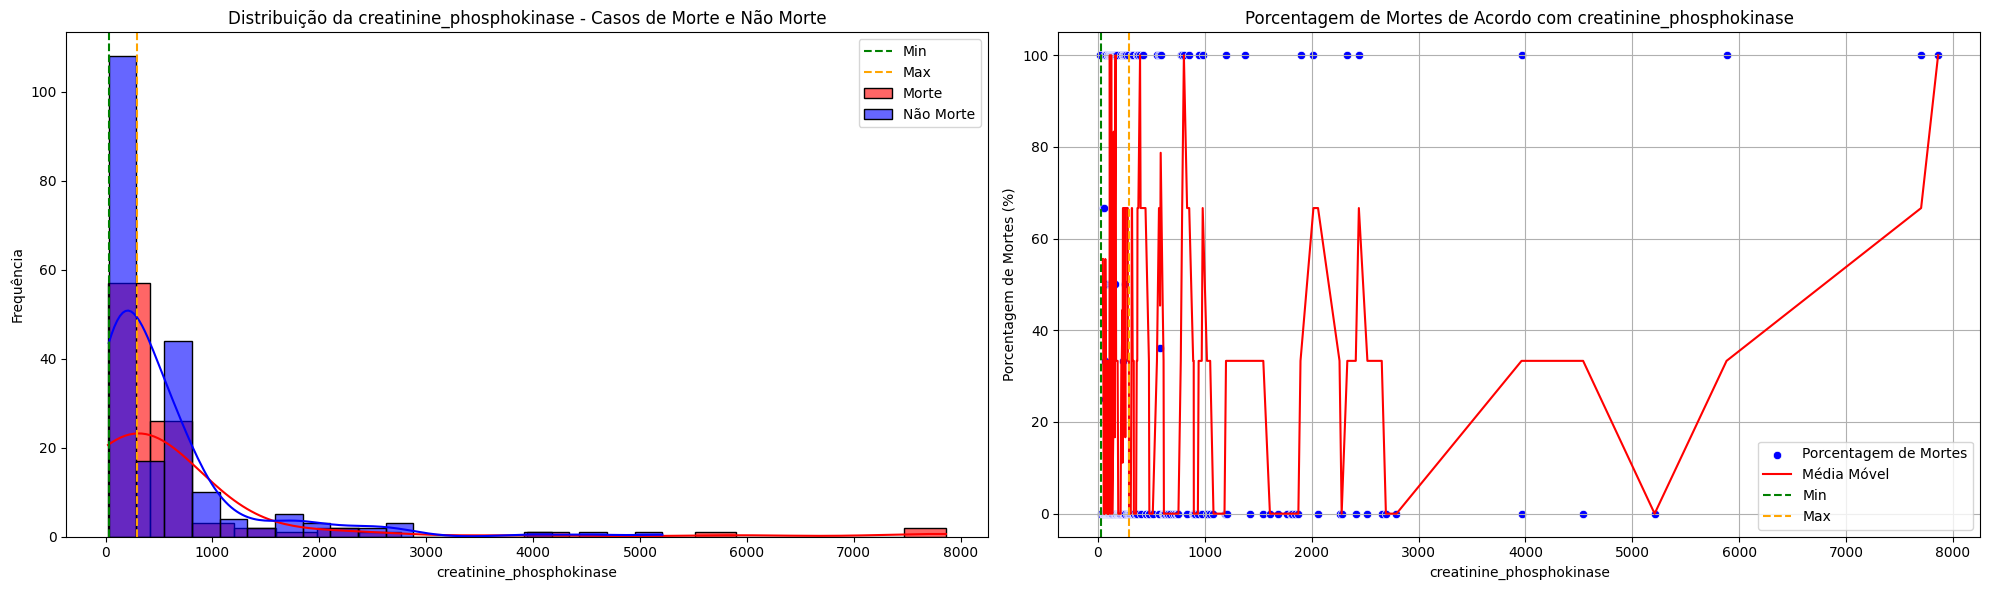

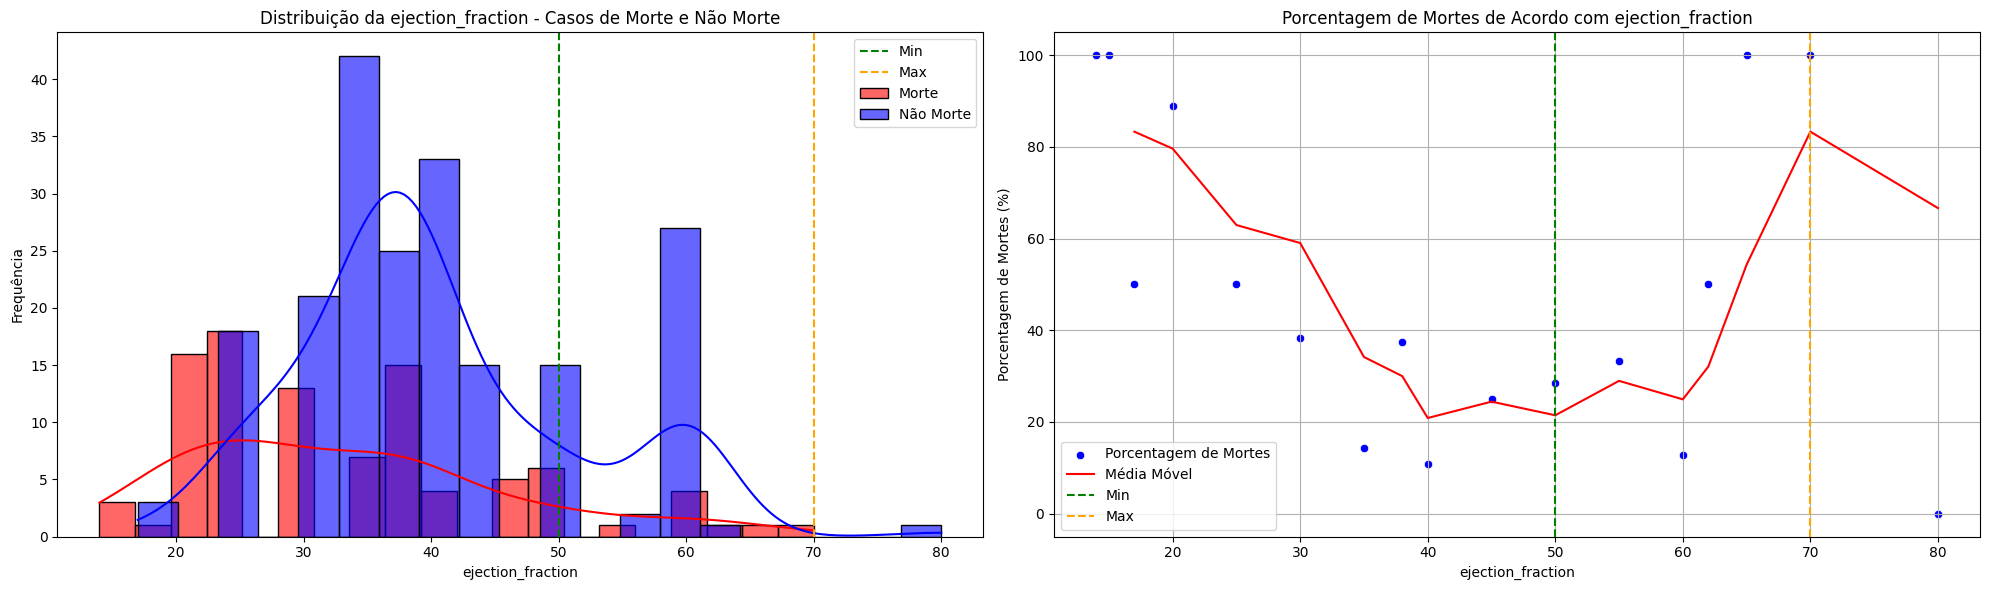

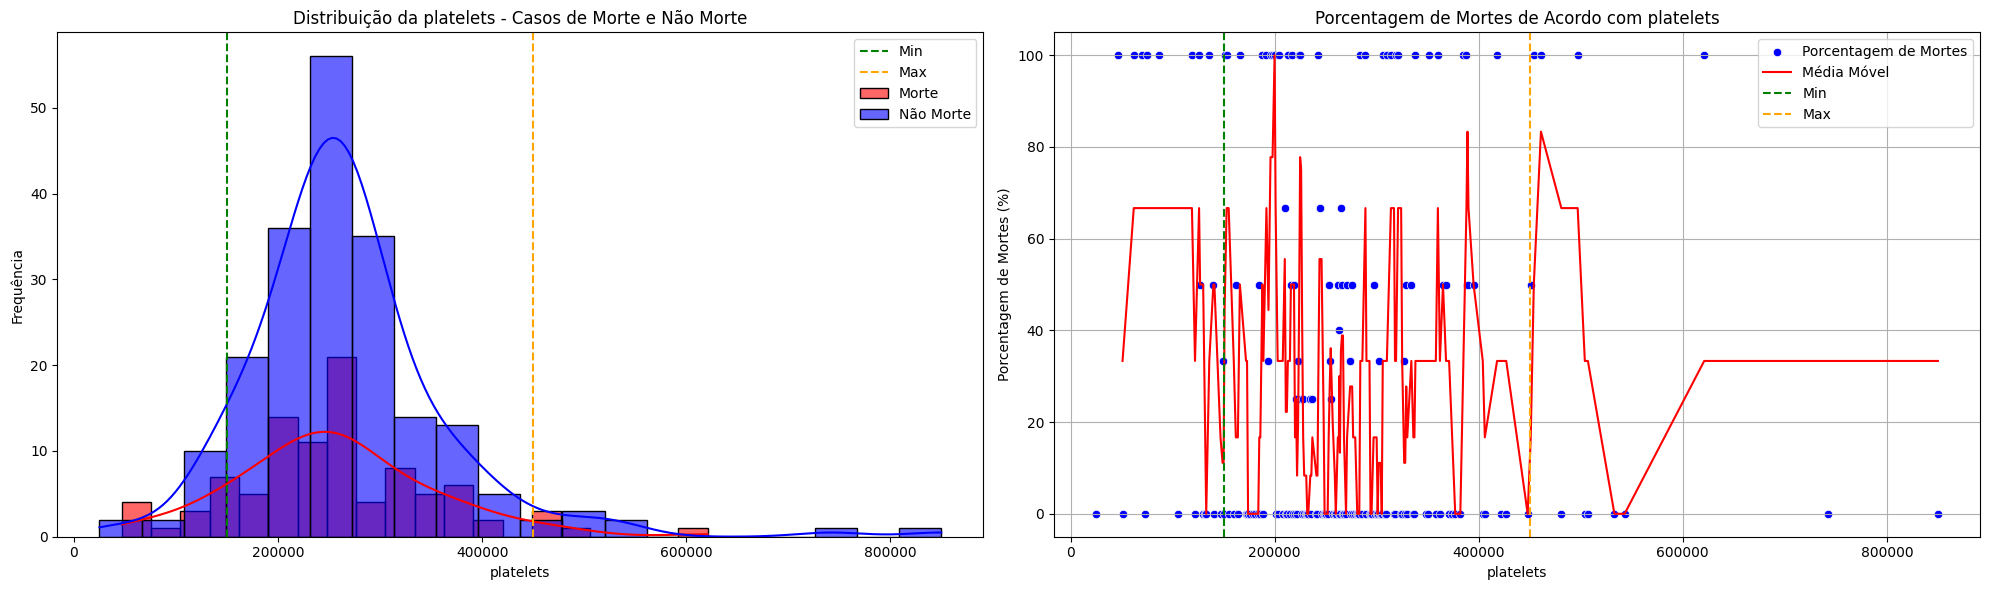

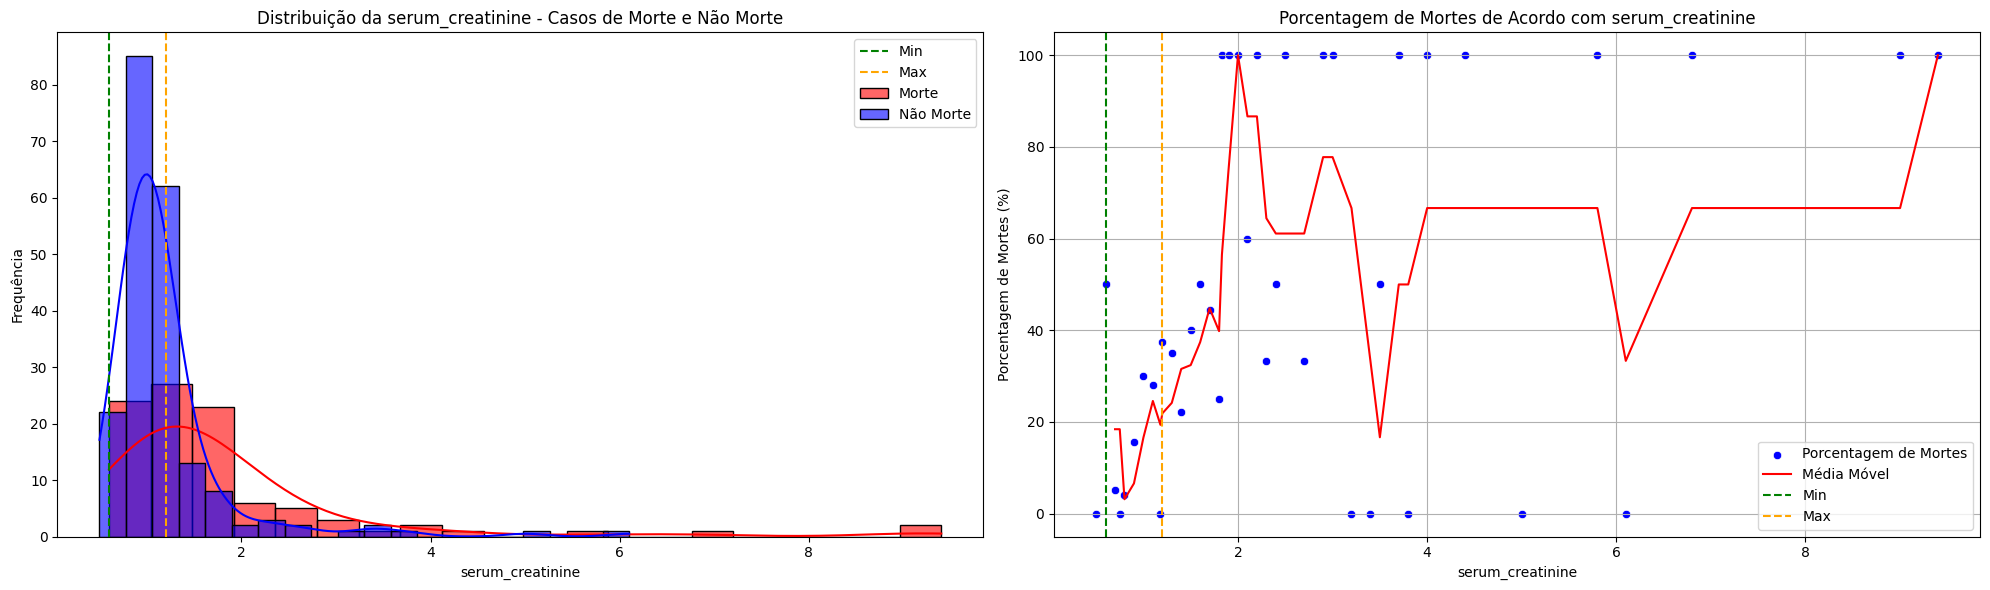

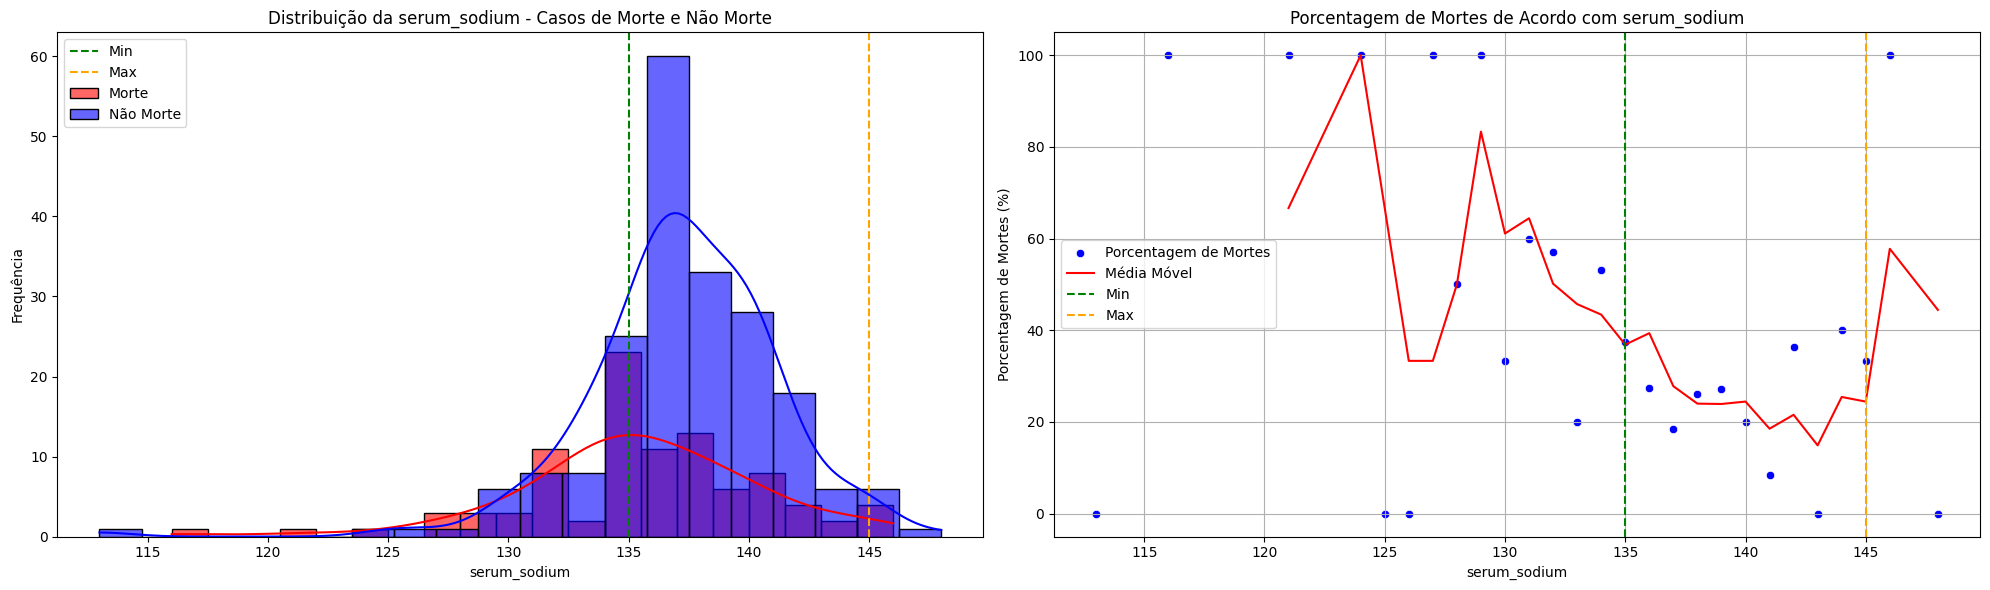

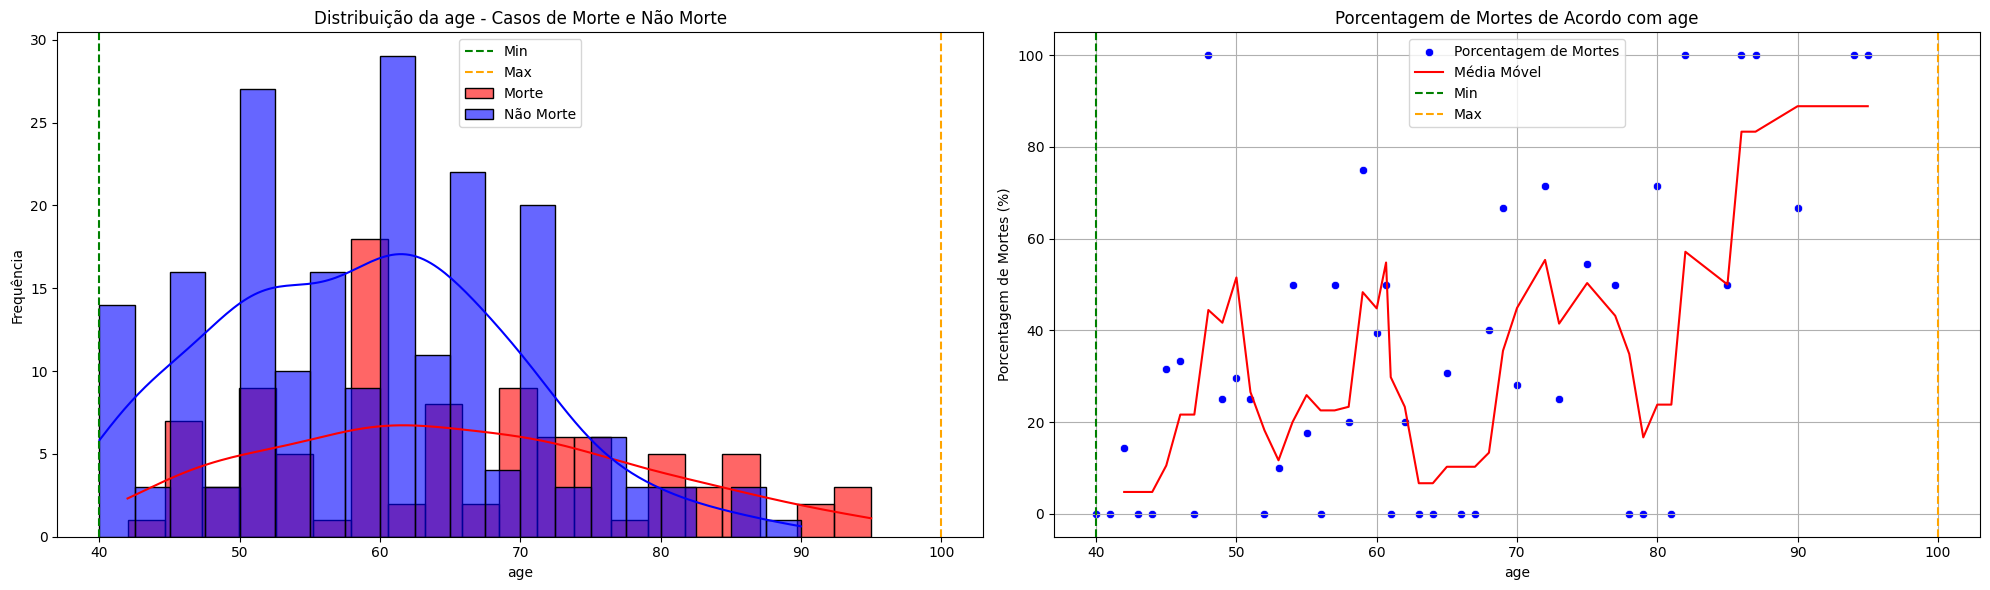

In [17]:
for var in normal_levels.keys():
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Histograma para casos de morte e não morte
    sns.histplot(df[df[LABEL] == 1][var], bins=20, kde=True, color='red', label='Morte', alpha=0.6, ax=axes[0])
    sns.histplot(df[df[LABEL] == 0][var], bins=20, kde=True, color='blue', label='Não Morte', alpha=0.6, ax=axes[0])

    # Adicionar linhas verticais para os valores mínimos e máximos
    axes[0].axvline(normal_levels[var]['min'], color='green', linestyle='--', label='Min')
    axes[0].axvline(normal_levels[var]['max'], color='orange', linestyle='--', label='Max')

    axes[0].set_title(f'Distribuição da {var} - Casos de Morte e Não Morte')
    axes[0].set_xlabel(var)
    axes[0].set_ylabel('Frequência')
    axes[0].legend()

    # Calcular a porcentagem de mortos de acordo com a variável
    age_death_percent = df.groupby(var)[LABEL].mean() * 100

    # Calcular a média móvel
    window_size = 3
    #window_size = 10
    age_death_percent_moving_avg = age_death_percent.rolling(window=window_size).mean()

    # Plotar a porcentagem de mortos de acordo com a idade
    sns.scatterplot(x=age_death_percent.index, y=age_death_percent.values, label='Porcentagem de Mortes', color='blue', ax=axes[1])
    sns.lineplot(x=age_death_percent_moving_avg.index, y=age_death_percent_moving_avg.values, label='Média Móvel', color='red', ax=axes[1])

    # Adicionar linhas verticais para os valores mínimos e máximos
    axes[1].axvline(normal_levels[var]['min'], color='green', linestyle='--', label='Min')
    axes[1].axvline(normal_levels[var]['max'], color='orange', linestyle='--', label='Max')

    axes[1].set_title(f'Porcentagem de Mortes de Acordo com {var}')
    axes[1].set_xlabel(var)
    axes[1].set_ylabel('Porcentagem de Mortes (%)')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_9567/3838958812.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=death_percent.index, y=death_percent.values, palette='viridis', ax=axes[1])


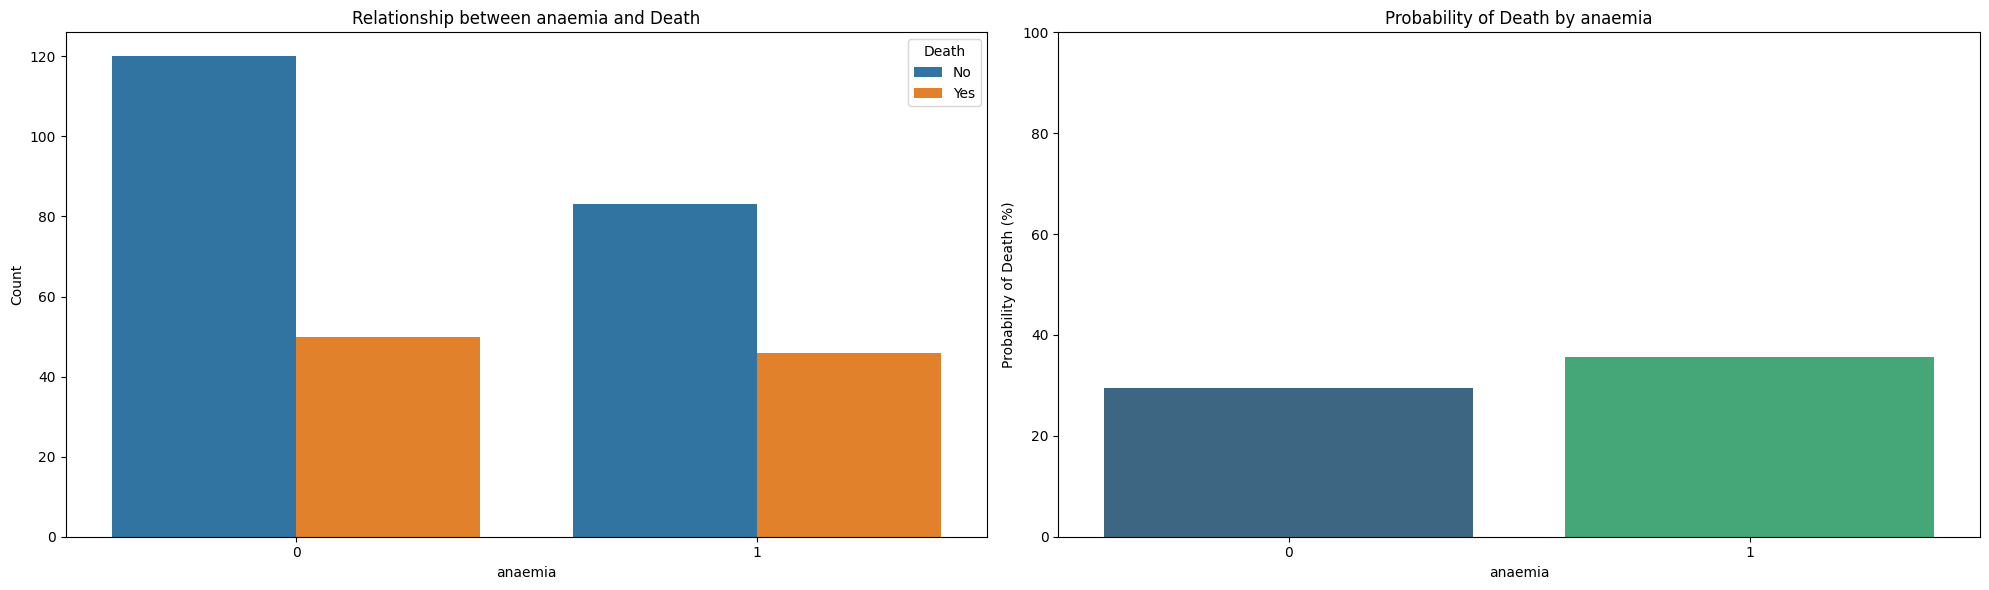

/tmp/ipykernel_9567/3838958812.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=death_percent.index, y=death_percent.values, palette='viridis', ax=axes[1])


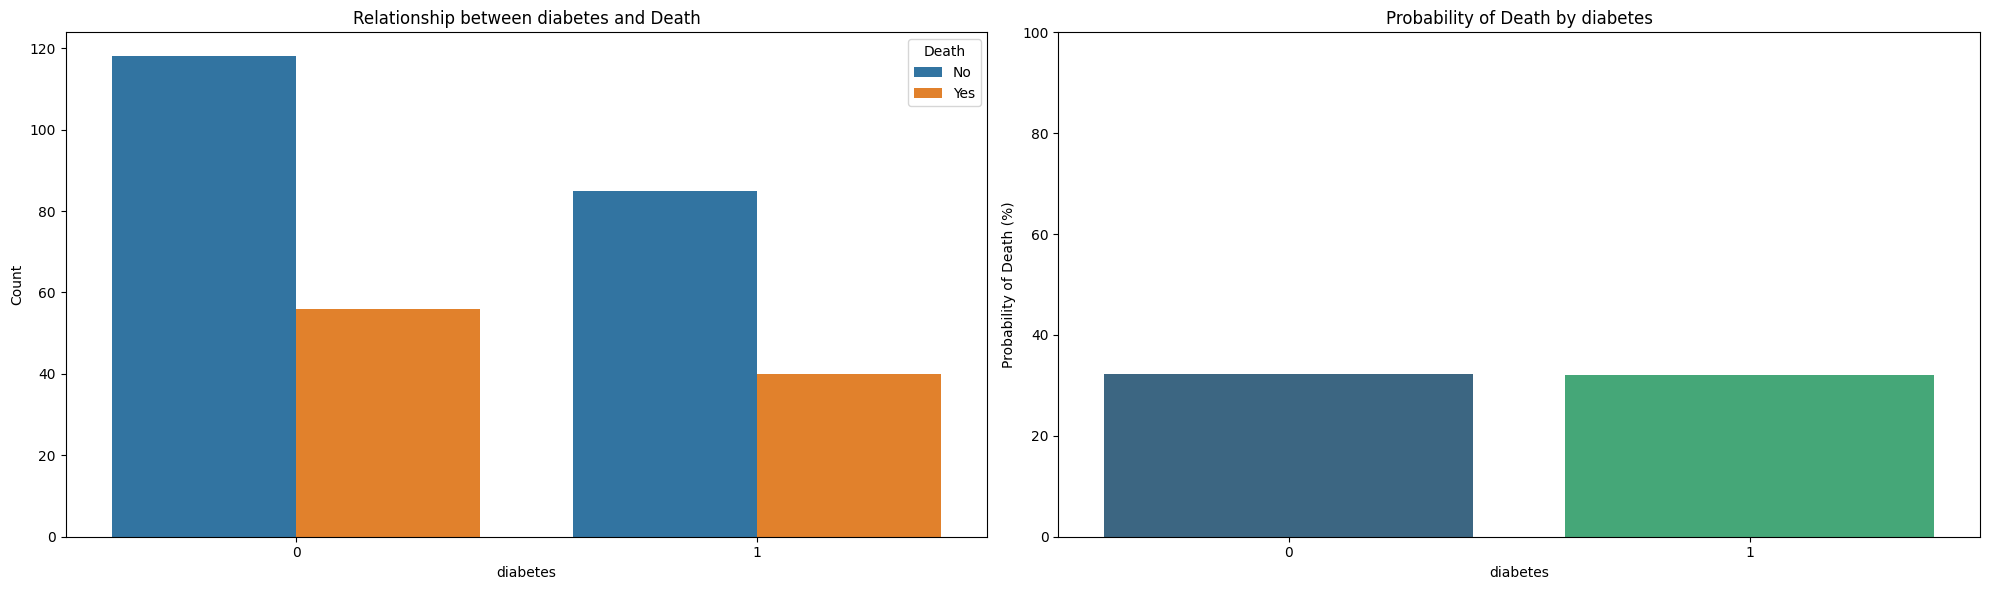

/tmp/ipykernel_9567/3838958812.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=death_percent.index, y=death_percent.values, palette='viridis', ax=axes[1])


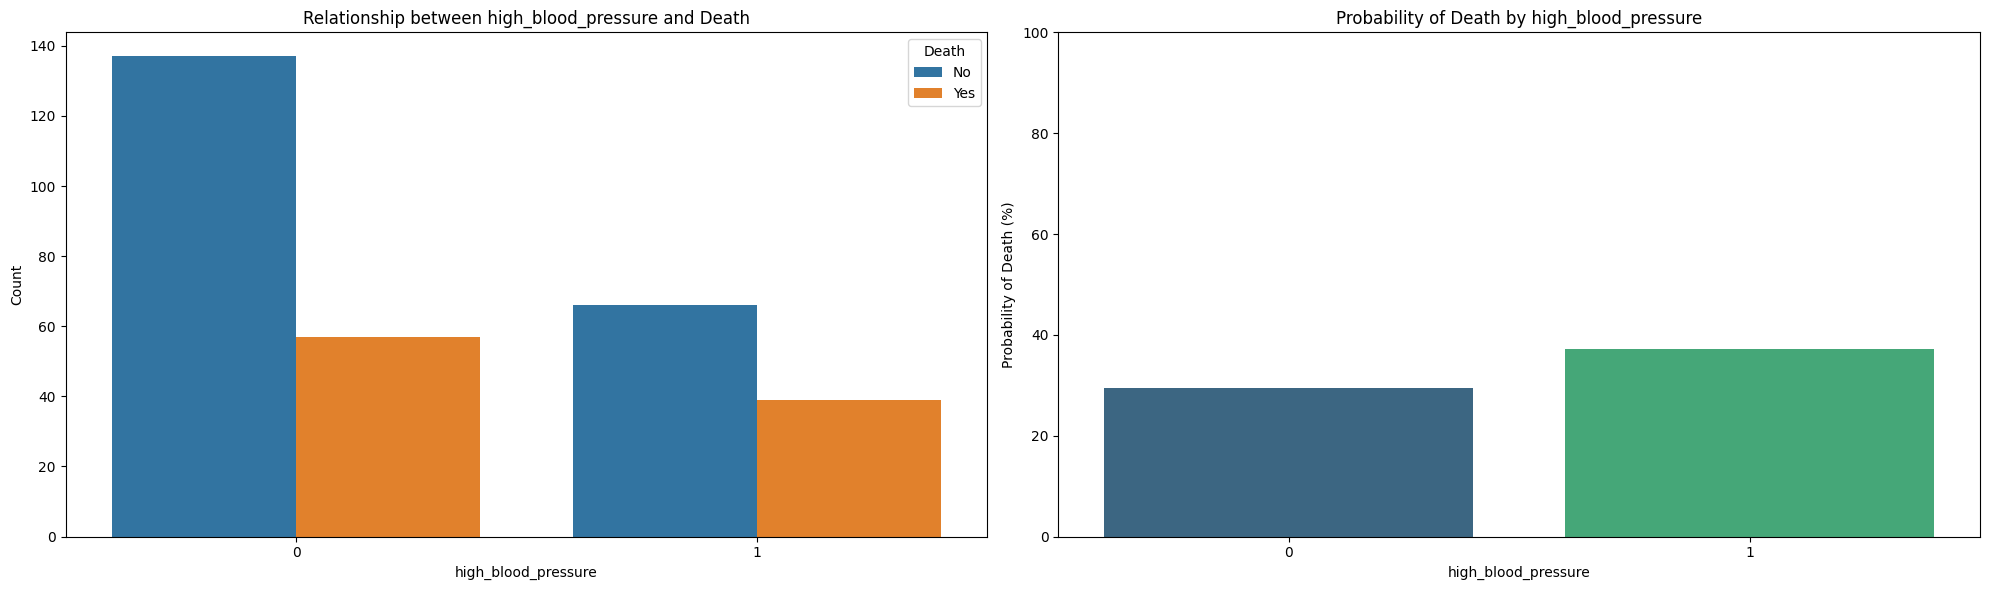

/tmp/ipykernel_9567/3838958812.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=death_percent.index, y=death_percent.values, palette='viridis', ax=axes[1])


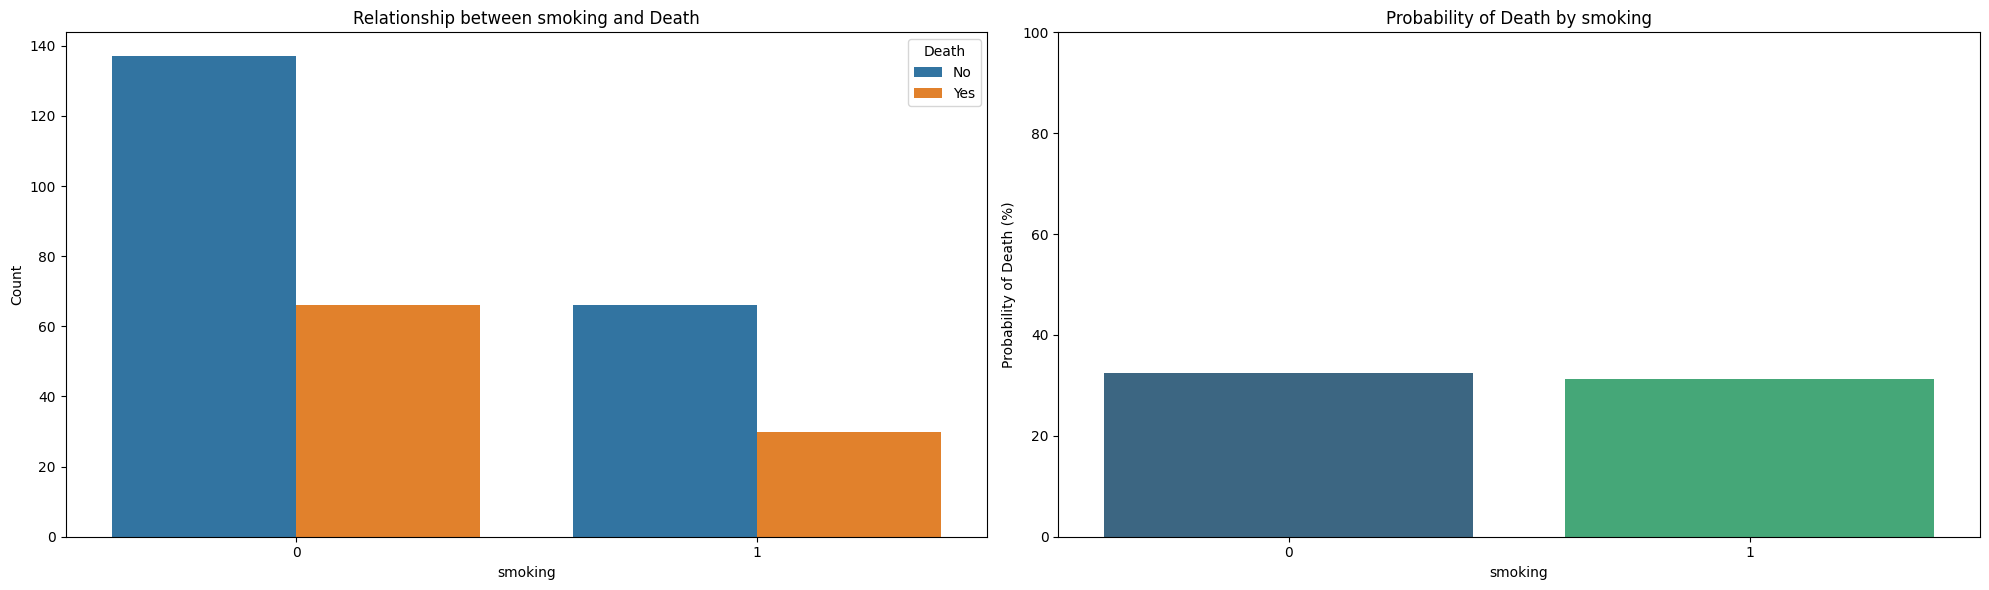

/tmp/ipykernel_9567/3838958812.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=death_percent.index, y=death_percent.values, palette='viridis', ax=axes[1])


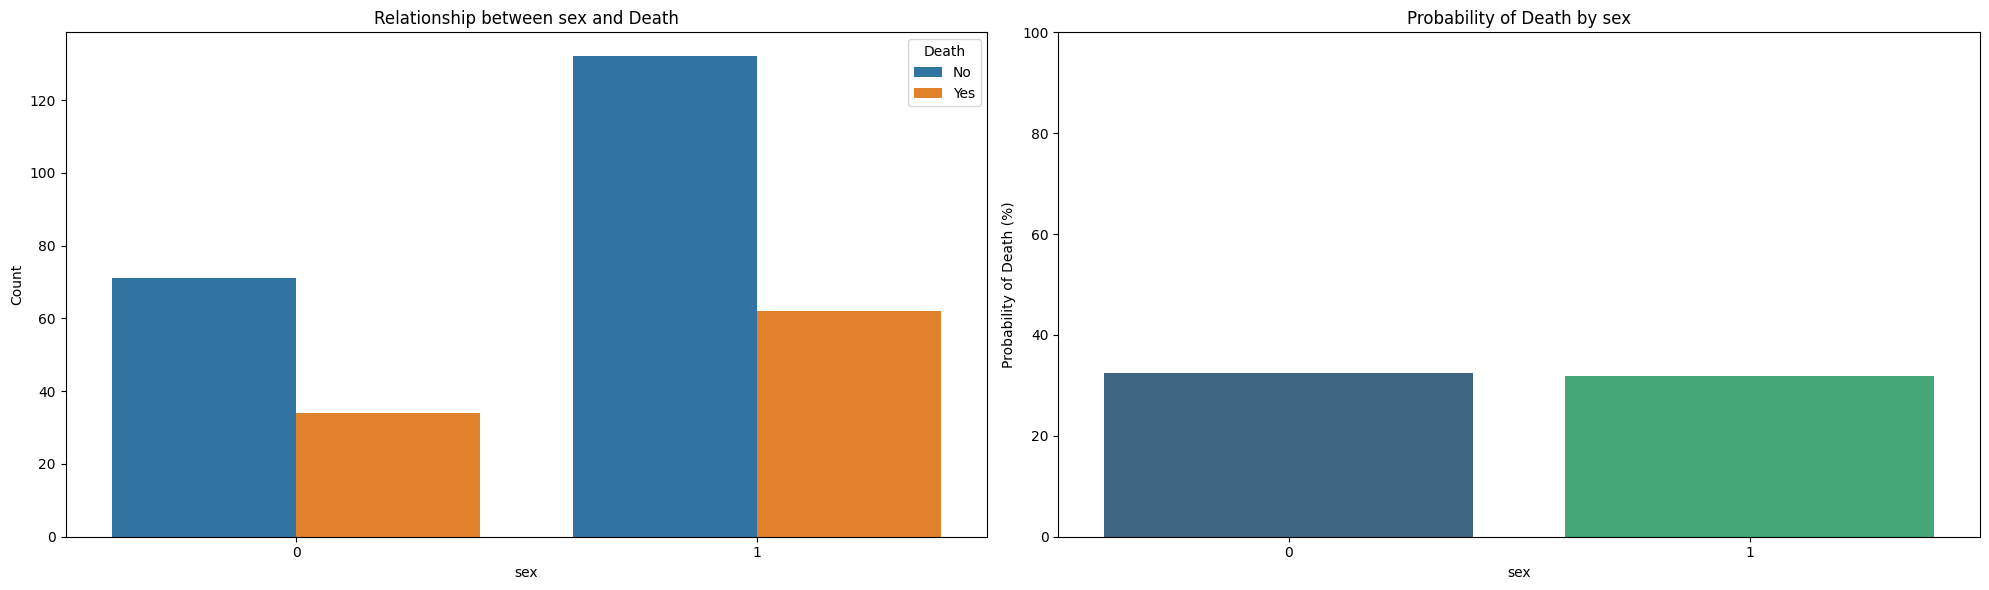

In [18]:

for variable in CATEGORICAL_FEATURES:
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Create a contingency table
    contingency_table = pd.crosstab(df[variable], df[LABEL])

    # Perform Chi-Square Test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # print(f"Chi-Square Test Statistic: {chi2}")
    # print(f"P-Value: {p}")

    # Visualize the relationship
    sns.countplot(x=variable, hue=LABEL, data=df, ax=axes[0])
    axes[0].set_xlabel(variable)
    axes[0].set_ylabel('Count')
    axes[0].set_title(f'Relationship between {variable} and Death')
    axes[0].legend(title='Death', loc='upper right', labels=['No', 'Yes'])

    # Calculate the percentage of deaths for each variable
    death_percent = df.groupby(variable)[LABEL].mean() * 100
    #print(f"Probability of death for {variable}:\n{death_percent}")

    # Plot the probability of death
    sns.barplot(x=death_percent.index, y=death_percent.values, palette='viridis', ax=axes[1])
    axes[1].set_xlabel(variable)
    axes[1].set_ylabel('Probability of Death (%)')
    axes[1].set_title(f'Probability of Death by {variable}')
    axes[1].set_ylim(0, 100)

    plt.tight_layout()
    plt.show()

1. Alta disponibilidade, ideal para produtos a serem utilizados na vida real
2. Feature time será descartada, pois isso não está disponível antes do paciente morrer
3. 


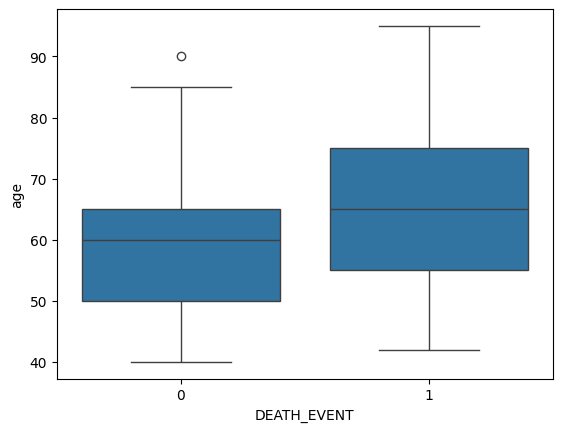

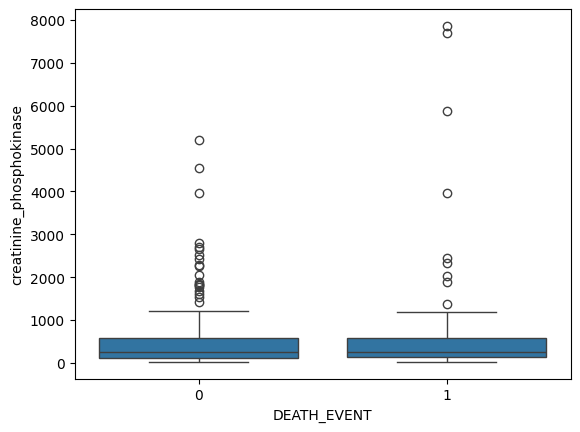

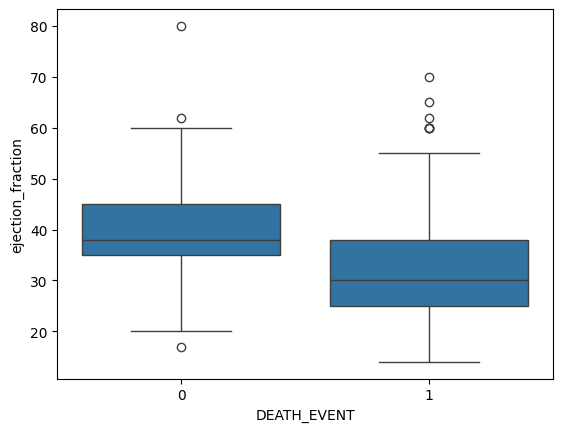

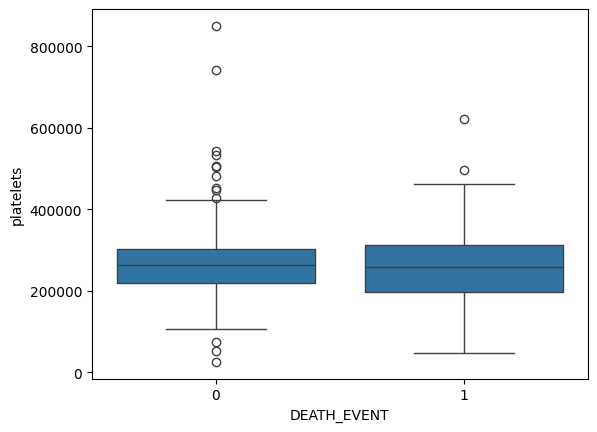

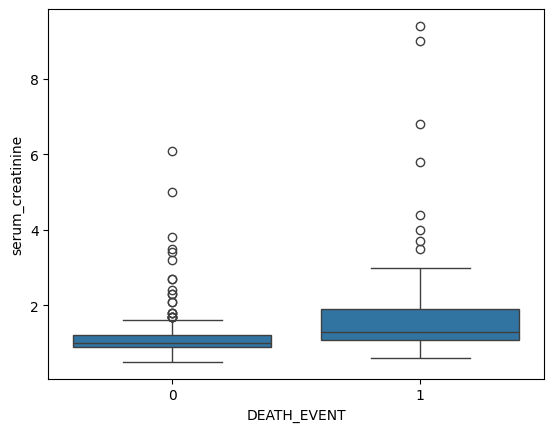

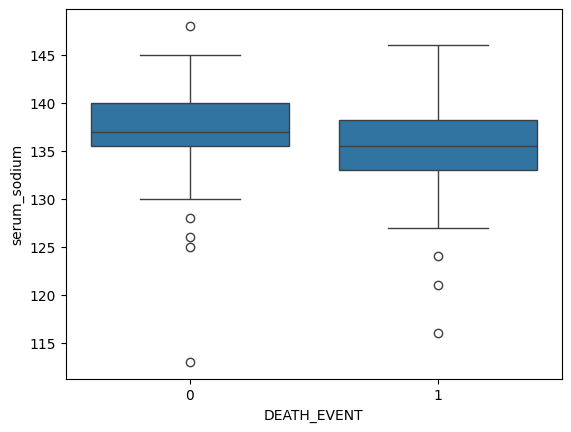

In [32]:
for col in NUMERICAL_FEATURES:
    plt.figure()
    sns.boxplot(x=LABEL, y=col, data=df)